In [1]:
## Import libraries

from platform import python_version
print(python_version())
import torch
print(torch.__version__)
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

import time
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from   matplotlib import pylab
sns.set_style("whitegrid")
np.random.seed(697)

from sklearn            import preprocessing
from sklearn            import metrics
from sklearn.metrics    import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.datasets   import make_classification
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.ensemble   import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

3.6.3
1.5.0


In [2]:
DATA_DIR = ''
#if torch.cuda.is_available():   
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
#def to_numpy(tensor):
#    '''converts a GPU tensor to a numpy array'''
#    return tensor.cpu().detach().numpy()

# Bunu bu aşamada yapmıyoruz. Sebebi data'yı cpu'da oluşturup sonra batch batch to.device ile gpu'ya aktaracağız.

In [3]:
f = h5.File('./el_data.h5', 'r') ## gives group
print('\033[1;35m Key name:\033[1;m', list(f.keys()))

 Key name: ['em_barrel_Lr0', 'em_barrel_Lr1', 'em_barrel_Lr1_fine', 'em_barrel_Lr2', 'em_barrel_Lr3', 'eventNumber', 'mcChannelNumber', 'p_ECIDSResult', 'p_Eratio', 'p_LHLoose', 'p_LHMedium', 'p_LHTight', 'p_LHValue', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_TruthOrigin', 'p_TruthType', 'p_charge', 'p_chi2', 'p_d0', 'p_d0Sig', 'p_dPOverP', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_e', 'p_et_calo', 'p_eta', 'p_f1', 'p_f3', 'p_firstEgMotherTruthOrigin', 'p_firstEgMotherTruthType', 'p_iffTruth', 'p_mean_charge', 'p_mean_chi2', 'p_mean_d0', 'p_mean_deta', 'p_mean_dphi', 'p_mean_efrac', 'p_mean_ndof', 'p_mean_pixhits', 'p_mean_scthits', 'p_mean_sigmad0', 'p_mean_trthits', 'p_mean_vertex', 'p_mean_z0', 'p_nTracks', 'p_ndof', 'p_numberOfSCTHits', 'p_phi', 'p_pt_track', 'p_qd0Sig', 'p_sct_weight_charge', 'p_sigmad0', 'p_tracks', 'p_truth_eta', 'p_truth_phi', 'p_truth_pt', 'p_weta2', 'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3', 'tracks', 'true_m']


In [4]:
file_name = h5.File('./el_data.h5', 'r') ## gives group
keys = list(file_name.keys())
print(keys)
#print(list(file_name[keys[0]]))
#print(list(file_name[keys[1]]))
#print(list(file_name[list(file_name.keys())[0]])) ## or
file_name.close()

['em_barrel_Lr0', 'em_barrel_Lr1', 'em_barrel_Lr1_fine', 'em_barrel_Lr2', 'em_barrel_Lr3', 'eventNumber', 'mcChannelNumber', 'p_ECIDSResult', 'p_Eratio', 'p_LHLoose', 'p_LHMedium', 'p_LHTight', 'p_LHValue', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_TruthOrigin', 'p_TruthType', 'p_charge', 'p_chi2', 'p_d0', 'p_d0Sig', 'p_dPOverP', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_e', 'p_et_calo', 'p_eta', 'p_f1', 'p_f3', 'p_firstEgMotherTruthOrigin', 'p_firstEgMotherTruthType', 'p_iffTruth', 'p_mean_charge', 'p_mean_chi2', 'p_mean_d0', 'p_mean_deta', 'p_mean_dphi', 'p_mean_efrac', 'p_mean_ndof', 'p_mean_pixhits', 'p_mean_scthits', 'p_mean_sigmad0', 'p_mean_trthits', 'p_mean_vertex', 'p_mean_z0', 'p_nTracks', 'p_ndof', 'p_numberOfSCTHits', 'p_phi', 'p_pt_track', 'p_qd0Sig', 'p_sct_weight_charge', 'p_sigmad0', 'p_tracks', 'p_truth_eta', 'p_truth_phi', 'p_truth_pt', 'p_weta2', 'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3', 'tracks', 'true_m']


In [5]:
def traverse_datasets(hdf_file):

    def h5_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'
            if isinstance(item, h5.Dataset): ## test for dataset
                yield (path, item)
            elif isinstance(item, h5.Group): ## test for group (go down)
                yield from h5_dataset_iterator(item, path)

    with h5.File(hdf_file, 'r') as f:
        for path, _ in h5_dataset_iterator(f):
            yield path

In [6]:
with h5.File('./el_data.h5', 'r') as f:
    for dset in traverse_datasets('./el_data.h5'):
        
        print('\033[1;35m Path:\033[1;m', dset)
        
        print('\033[1;36m Shape:\033[1;m', f[dset].shape)
        
        print('\033[1;33m Data type:\033[1;m', f[dset].dtype)
        
        print('\n')

 Path: /em_barrel_Lr0
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /em_barrel_Lr1
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /em_barrel_Lr1_fine
 Shape: (14675640, 56, 11)
 Data type: float16


 Path: /em_barrel_Lr2
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /em_barrel_Lr3
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /eventNumber
 Shape: (14675640,)
 Data type: int32


 Path: /mcChannelNumber
 Shape: (14675640,)
 Data type: int32


 Path: /p_ECIDSResult
 Shape: (14675640,)
 Data type: float16


 Path: /p_Eratio
 Shape: (14675640,)
 Data type: float16


 Path: /p_LHLoose
 Shape: (14675640,)
 Data type: int32


 Path: /p_LHMedium
 Shape: (14675640,)
 Data type: int32


 Path: /p_LHTight
 Shape: (14675640,)
 Data type: int32


 Path: /p_LHValue
 Shape: (14675640,)
 Data type: float16


 Path: /p_Reta
 Shape: (14675640,)
 Data type: float16


 Path: /p_Rhad
 Shape: (14675640,)
 Data type: float16


 Path: /p_Rphi
 Shape: (14675640,)
 Data type: f

In [11]:
def make_sample(data_file, batch_size, all_features, images, upscale=False, denormalize=False, index=0):
    data = h5.File(data_file, 'r')
    idx_1, idx_2 = index*batch_size, (index+1)*batch_size
    sample_dict  = dict([key, data[key][idx_1:idx_2]] for key in all_features)
    if images != [] and denormalize:
        energy = sample_dict['p_e']
        for key in images: sample_dict[key] = sample_dict[key] * energy[:, np.newaxis, np.newaxis]
        sample_dict['tracks'][:,:,0] = sample_dict['tracks'][:,:,0] * energy[:, np.newaxis]
    if images != [] and upscale:
        for i in images: sample_dict[i] = resize_images(np.float32(sample_dict[i]), target_shape=(56,11))
    return sample_dict

In [12]:
images    = ['em_barrel_Lr0',  'em_barrel_Lr1', 'em_barrel_Lr2', 'em_barrel_Lr3',
             'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3']
#images    = ['em_barrel_Lr1_fine']
tracks    = ['tracks' ]
scalars   = ['p_Eratio', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_d0', 'p_d0Sig', 'p_dPOverP',
             'p_deltaPhiRescaled2', 'p_deltaEta1', 'p_f1', 'p_f3', 'p_numberOfSCTHits', 'p_weta2']
others    = ['p_TruthType', 'p_iffTruth', 'p_LHTight', 'p_LHMedium', 'p_LHLoose', 'p_e']
#train_features = {'images':images, 'tracks':tracks, 'scalars':scalars}
train_features = {'images':images, 'tracks':[], 'scalars':[]}
all_features   = np.sum(list(train_features.values())) + others
if train_features['images'] == []: args.n_type = 'FCN'

In [13]:
torch.cuda.get_device_properties(device=None).total_memory

34089730048

In [14]:
data_file = './el_data2.h5'

In [15]:
# n_e = 1000000
n_e = 14675640
xtrain_data = make_sample(data_file, n_e, all_features, train_features['images'], upscale=False)

In [16]:
train_data = [ np.expand_dims(np.float32(xtrain_data[key]),axis = 1)  for key in np.sum(list(train_features.values()))]
#train_data = [np.float32(train_data[key])[:,np.newaxis,:,:]  for key in np.sum(list(train_features.values()))]
#train_data = [np.float32(train_data[key]) for key in np.sum(list(train_features.values()))]

In [17]:
for element in train_data:
    print(element.shape)

(14675640, 1, 7, 11)
(14675640, 1, 7, 11)
(14675640, 1, 7, 11)
(14675640, 1, 7, 11)
(14675640, 1, 7, 11)
(14675640, 1, 7, 11)
(14675640, 1, 7, 11)


In [18]:
x = np.concatenate(train_data, axis=1)
print(x.shape)

(14675640, 7, 7, 11)


In [19]:
def make_labels(data, n_classes):
    if   n_classes == 2:
        labels = np.where(np.logical_or(data['p_TruthType']==2, data['p_TruthType']==4), 0, 1)
    elif n_classes == 5:
        truth  = data['p_iffTruth']
        labels = np.where(truth==2, 0, 4     )
        labels = np.where(truth==3, 1, labels)
        labels = np.where(np.logical_or (truth==1, truth==10), 2, labels)
        labels = np.where(np.logical_and(truth>=7, truth<= 9), 3, labels)
    elif n_classes == 9:
        labels = data['p_iffTruth']
        labels = np.where(labels== 9, 4, labels)
        labels = np.where(labels==10, 6, labels)
    else:
        print('\nCLASSIFIER:', n_classes, 'classes not supported -> exiting program\n')
        sys.exit()
    return labels

In [20]:
n_classes = 2
y = make_labels(xtrain_data, n_classes)
print(y.shape)

(14675640,)


In [21]:
del xtrain_data
del train_data

In [22]:
#from torch.utils.data import DataLoader, random_split

In [23]:
#train_ds, val_ds = random_split(x, [90000, 10000])
#len(train_ds), len(val_ds)

In [24]:
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)
shuffle_idx = np.random.permutation(x.shape[0])
x = x[shuffle_idx]
y = y[shuffle_idx]

In [25]:
#x /= 0.0052  bu 56 x 11 imageler için geçerli

In [26]:
train_frac = 0.9
idx = int(train_frac * len(x))
x_train, x_test = x[:idx], x[idx:]
y_train, y_test = y[:idx], y[idx:]

In [27]:
## Hyperparameters
#num_epochs=20
num_epochs=10
#num_classes=10
nw=1
bs1=5000
bs2=5000
#bs=64
wd=1e-5
lr=1e-5
momentum=0.9

In [28]:
train_tensor_x = torch.stack([torch.Tensor(i) for i in x_train])
train_tensor_y = torch.stack([torch.zeros([1])+i for i in y_train])
train_tensor_y = train_tensor_y.type(torch.long).squeeze(1)
#train_tensor_ycpu = train_tensor_y.to('cpu')
#train_tensor_xcpu = train_tensor_x.to('cpu')

In [29]:
print('\033[1;33m tensor_x type: \033[1;m', train_tensor_x.type())
print('\033[1;35m tensor_x dtype: \033[1;m', train_tensor_x.dtype)
print('\033[1;36m tensor_x num of dims: \033[1;m', train_tensor_x.dim())
print('\033[1;34m tensor_x Shape:\033[1;m', train_tensor_x.shape)
print('\033[1;33m tensor_y type: \033[1;m', train_tensor_y.type())
print('\033[1;35m tensor_y dtype: \033[1;m', train_tensor_y.dtype)
print('\033[1;36m tensor_y num of dims: \033[1;m', train_tensor_y.dim())
print('\033[1;34m tensor_y Shape:\033[1;m', train_tensor_y.shape)

 tensor_x type:  torch.FloatTensor
 tensor_x dtype:  torch.float32
 tensor_x num of dims:  4
 tensor_x Shape: torch.Size([13208076, 7, 7, 11])
 tensor_y type:  torch.LongTensor
 tensor_y dtype:  torch.int64
 tensor_y num of dims:  1
 tensor_y Shape: torch.Size([13208076])


In [30]:
del x_train
del y_train

In [31]:
test_tensor_x = torch.stack([torch.Tensor(i) for i in x_test])
test_tensor_y = torch.stack([torch.zeros([1])+i for i in y_test])
test_tensor_y = test_tensor_y.type(torch.long).squeeze(1)
#test_tensor_ycpu = test_tensor_y.to('cpu')
#test_tensor_xcpu = test_tensor_x.to('cpu')

In [32]:
del x_test
del y_test

In [33]:
#torch.cuda.empty_cache()

In [34]:
print('\033[1;33m tensor_x type: \033[1;m', test_tensor_x.type())
print('\033[1;35m tensor_x dtype: \033[1;m', test_tensor_x.dtype)
print('\033[1;36m tensor_x num of dims: \033[1;m', test_tensor_x.dim())
print('\033[1;34m tensor_x Shape:\033[1;m', test_tensor_x.shape)
print('\033[1;33m tensor_x type: \033[1;m', test_tensor_y.type())
print('\033[1;35m tensor_x dtype: \033[1;m', test_tensor_y.dtype)
print('\033[1;36m tensor_x num of dims: \033[1;m', test_tensor_y.dim())
print('\033[1;34m tensor_x Shape:\033[1;m', test_tensor_y.shape)

 tensor_x type:  torch.FloatTensor
 tensor_x dtype:  torch.float32
 tensor_x num of dims:  4
 tensor_x Shape: torch.Size([1467564, 7, 7, 11])
 tensor_x type:  torch.LongTensor
 tensor_x dtype:  torch.int64
 tensor_x num of dims:  1
 tensor_x Shape: torch.Size([1467564])


In [35]:
train_transformer = transforms.Compose([transforms.ToTensor()])
val_transformer = transforms.Compose([transforms.ToTensor()])

In [36]:
train_tensor_x.transform=train_transformer
test_tensor_x.transform=val_transformer

In [37]:
#train_transformer = transforms.Compose(transforms.Normalize(mean=[0.485, 0.456, 0.406],
#       std=[0.229, 0.224, 0.225]))
#val_transformer = transforms.Compose([transforms.ToTensor()]transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]))

In [38]:
train_dataset = torch.utils.data.TensorDataset(train_tensor_x, train_tensor_y) 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs1, num_workers=nw, shuffle=True) 
valid_dataset = torch.utils.data.TensorDataset(test_tensor_x, test_tensor_y) 
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=bs2, num_workers=nw, shuffle=False) 

#Burda shuffle true false vs gibi seçenekleri de alabiliriz
#Number of workers'ı 1'den farklı alınca sorun çıkıyor çözemedim.

In [39]:
loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_tensor_x), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std()

(tensor(0.0014), tensor(1.0105))

In [40]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [43]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [44]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [41]:
#for xb, yb in valid_loader:
#    print('xb.device:', xb.device)
#    print('yb:', yb)
#    print(xb.shape)
#    print(yb.shape)    
#    break

xb.device: cuda:0
yb: tensor([1, 1, 1,  ..., 1, 0, 1], device='cuda:0')
torch.Size([1467, 7, 7, 11])
torch.Size([1467])


In [45]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [46]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
device = get_default_device()
device

device(type='cuda')

In [48]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [49]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, valid_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [50]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(7, 32, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(1), 
            nn.Linear(13*17*16, 100),
            nn.ReLU(),
            nn.Linear(100, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [51]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(7, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Flatten()
    (13): Linear(in_features=3536, out_features=100, bias=True)
    (14): ReLU()
    (15): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [52]:
model = to_device(CnnModel(), device)

In [53]:
evaluate(model, valid_loader)

{'val_loss': 0.6929271817207336, 'val_acc': 0.6295889019966125}

In [54]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [55]:
history = fit(num_epochs, lr, model, train_loader, valid_loader, opt_func)

Epoch [0], train_loss: 0.2017, val_loss: 0.1862, val_acc: 0.9375
Epoch [1], train_loss: 0.1851, val_loss: 0.1831, val_acc: 0.9387
Epoch [2], train_loss: 0.1819, val_loss: 0.1791, val_acc: 0.9400
Epoch [3], train_loss: 0.1792, val_loss: 0.1783, val_acc: 0.9406
Epoch [4], train_loss: 0.1778, val_loss: 0.1772, val_acc: 0.9408
Epoch [5], train_loss: 0.1767, val_loss: 0.1769, val_acc: 0.9412
Epoch [6], train_loss: 0.1759, val_loss: 0.1761, val_acc: 0.9414
Epoch [7], train_loss: 0.1752, val_loss: 0.1759, val_acc: 0.9416
Epoch [8], train_loss: 0.1748, val_loss: 0.1769, val_acc: 0.9409
Epoch [9], train_loss: 0.1742, val_loss: 0.1743, val_acc: 0.9419


In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

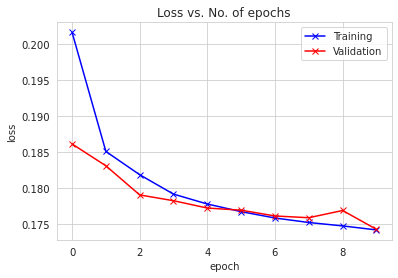

In [57]:
plot_losses(history)

In [58]:
torch.save(model.state_dict(), 'cnn_jovi.pth')